In [10]:
# Python calculation for the example and exercise from Lecture 4 notes
import numpy as np
import os
import math
import pandas as pd
import scipy.stats as stat
import scipy.interpolate
import statistics
from statistics import NormalDist

In [11]:
aapl = pd.read_excel("./data/hist_data.xlsm", sheet_name = 'AAPL')
msft = pd.read_excel("./data/hist_data.xlsm", sheet_name = 'MSFT')
f = pd.read_excel("./data/hist_data.xlsm", sheet_name = 'F')
bac = pd.read_excel("./data/hist_data.xlsm", sheet_name = 'BAC')
sofr_curve = pd.read_excel("./data/hist_data.xlsm", sheet_name = 'SofrCurve')

# Extract "T" as a separate array
T_array = sofr_curve["T"].values
df_transposed = sofr_curve[sofr_curve.columns[2:]].T
df_transposed.reset_index(inplace=True)
col_names = ['Date'] + list(sofr_curve['Tenor'])
df_transposed.columns = col_names

sofr_curve = df_transposed[['Date'] + list(df_transposed.columns[7:17])]
df_stocks = pd.concat([aapl,
                        msft['Adj Close'],
                        f['Adj Close'],
                        bac['Adj Close']],axis=1)
df_stocks.columns = ['Date', 'aapl', 'msft', 'f', 'bac']

df_returns = df_stocks.merge(sofr_curve,        # TODO change sofr curve to be modelled with change in rate rather than return
                        on=['Date'],
                        how='outer')\
                        .ffill()\
                        .drop(columns=['Date'])\
                        .pct_change()\
                        .dropna()

df_returns.head()

,aapl,msft,f,bac,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
1,-0.017543,-0.017059,0.002244,0.004439,0.011215,0.009846,0.008140,0.007351,0.005731,0.003218,0.000754,-0.001141,-0.002596,-0.003849
2,-0.037305,-0.035368,-0.025373,-0.003039,0.004977,0.010528,0.009553,0.006256,0.003865,0.003057,0.002871,0.002624,0.002407,0.002457
3,-0.042405,-0.026579,0.015314,-0.005542,0.014624,0.024133,0.025373,0.023414,0.020974,0.019620,0.018464,0.016548,0.014541,0.013280
4,-0.001947,0.033326,0.018854,0.025077,-0.008229,-0.010659,-0.010219,-0.007710,-0.005036,-0.002922,-0.000975,0.001187,0.003311,0.005084
5,0.003902,0.029270,0.014064,0.005980,0.009036,0.011631,0.011503,0.009947,0.008235,0.007935,0.008467,0.008905,0.009056,0.008932


5.478947907901089e-06

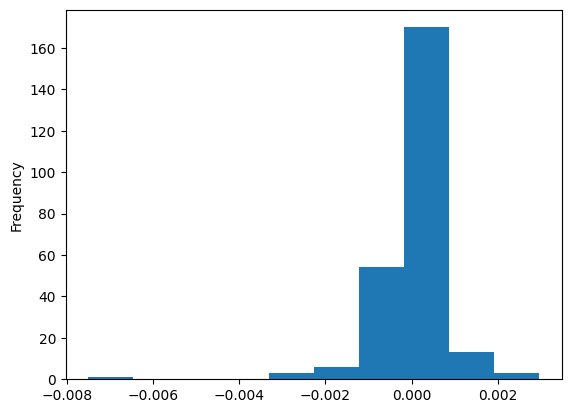

In [62]:
sofr_curve.diff()['1Y'].plot(kind='hist')
stat.normaltest(sofr_curve.diff()['5Y'][1:])[1]

In [63]:
stat.normaltest(sofr_curve['5Y'].pct_change()[1:])[1]

7.925320539542195e-05

<Axes: ylabel='Frequency'>

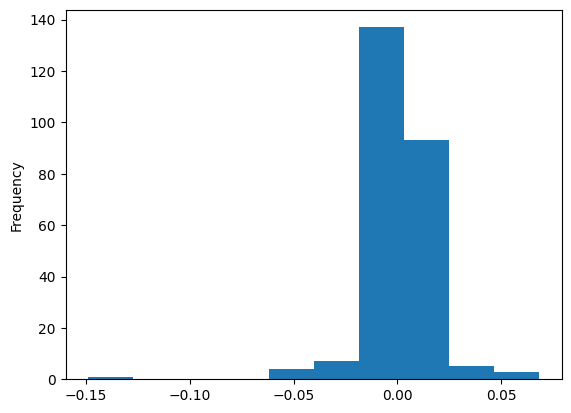

In [46]:
sofr_curve['1Y'].pct_change().plot(kind='hist')


In [29]:
sofr_curve = pd.read_excel("./data/hist_data.xlsm", sheet_name = 'SofrCurve')

# Extract "T" as a separate array
T_array = sofr_curve["T"].values
df_transposed = sofr_curve[sofr_curve.columns[2:]].T
df_transposed.reset_index(inplace=True)
col_names = ['Date'] + list(sofr_curve['Tenor'])
df_transposed.columns = col_names

sofr_curve = df_transposed[['Date'] + list(df_transposed.columns[7:17])]
sofr_curve[sofr_curve.columns[1:]].head()

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
0,0.046449,0.044583,0.042002,0.040318,0.039297,0.038534,0.037979,0.037648,0.037465,0.037353
1,0.046970,0.045022,0.042344,0.040614,0.039522,0.038658,0.038007,0.037605,0.037368,0.037209
2,0.047203,0.045496,0.042749,0.040868,0.039675,0.038776,0.038117,0.037704,0.037458,0.037300
3,0.047894,0.046594,0.043833,0.041825,0.040507,0.039537,0.038820,0.038328,0.038002,0.037796
4,0.047500,0.046097,0.043385,0.041503,0.040303,0.039421,0.038782,0.038373,0.038128,0.037988


In [28]:
sofr_curve = pd.read_excel("./data/hist_data.xlsm", sheet_name = 'SofrCurve')

# Extract "T" as a separate array
T_array = sofr_curve["T"].values
df_transposed = sofr_curve[sofr_curve.columns[2:]].T
df_transposed[[10]]

,10
2022-10-31 00:00:00,0.039297
2022-11-01 00:00:00,0.039522
2022-11-02 00:00:00,0.039675
2022-11-03 00:00:00,0.040507
2022-11-04 00:00:00,0.040303
...,...
2023-10-24 00:00:00,0.044305
2023-10-25 00:00:00,0.045200
2023-10-26 00:00:00,0.044086
2023-10-27 00:00:00,0.043762


## For Full Revaluation
$$\begin{aligned}
P_0 &= 100mio P_swap_0 + 1mio AAPL_0 + 1mio MSFT_0 + 1mio F + 1mio BAC_0     \\
P_1 &= 100mio P_swap_1 + 1mio AAPL_1 + 1mio MSFT_1 + 1mio F_1 + 1mio BAC_1   \\

\Delta_1 L &= P_1 - P_0  \\
&=  \left[ 1e8 S_{swap}(1) +  S_{aapl}(1)  +  S_{msft}(1)  +  S_{f}(1)  +  S_{bac}(1) \right] \\
    & \, \,- \left[ 1e8 S_{swap}(0) +  S_{aapl}(0)  +  S_{msft}(0)  +  S_{f}(0)  +  S_{bac}(0)  \right] \\
    &= \left[ 1e8 S_{swap}(1) - 1e8 S_{swap}(0) \right] + \left[  S_{aapl}(1) -  S_{aapl}(0) \right] + \left[  S_{msft}(1) -  S_{msft}(0) \right] \\
    & \,\, + \left[  S_{f}(1) -  S_{f}(0) \right]  + \left[  S_{bac}(1) -  S_{bac}(0) \right] \\         \\
\Delta_1 L    &= N \left[ \sum_{i=1}^T PV01_i \times \Delta R_i  \right] +  S_{aapl}(0) R_{aapl}^1  + S_{msft}(0)  R_{msft}^1  + S_{f}(0)  R_{f}^1  + S_{bac}(0) R_{bac}^1 \\         \\
\end{aligned}$$

### Pricing swap for full eval
compute changes in zero rate based on sample $(Z_{1} = Z_0 * (1+R_1))$ use new SOFT curve  to price swap at 4.2%


## For Sensitivity Analysis
$$\begin{aligned}
\Delta_1 L (\mu , \sigma^2) \\
\\
\mu \approx &100mio \mathbb{E}[\Delta_{swap}] + 1mio \mathbb{E}[\Delta_{aapl} + \Delta_{msft}  + \Delta_{f}  + \Delta_{bac}]        \\

\sigma^2 \approx &\text{Var}(100mio\Delta_{swap}) + \text{Var}(1mio [\Delta_{aapl} + \Delta_{msft}  + \Delta_{f}  + \Delta_{bac}])
\end{aligned}$$

### Pricing swap for sensitivity change 
get partial differential by changing one tenor by 1 bp then mark the change in PV.

$$
PV01_i = \frac{S(0,r_i + \Delta_{r_i}) - S(0,r_i)}{\Delta_{r_i}}
$$
For our model, we use $\Delta_{r_i} = 0.0001$
$$\begin{aligned}
\Delta PV &= N \left[ \sum_{i=1}^T PV01_i \times \Delta_{r_i} \right]  \\ 

\Delta PV &= N \left[ \sum_{i=1}^T PV01_i \times  R_{r_i} PV_0^i \right]  

\end{aligned}$$
where N is the notional of swap and $\Delta_{r_i} =  R_{r_i} PV_0^i$

---

# Useful functions and constants

1. Make a function to calculate payer swap
2. Get discount factors
3. Calculate initial value of swap
4. Calculate PV01:\
    a. change the value of each related zero rate by one bp an take note of PV change as partial derivative of PV for one bp change

In [ ]:
def payer_swap_10y(ls_df, swap_rate):
    """
    Retun value of payer swap
    parameters
        ls_df: list of discount factors
        swap_rate: strike of swap
    fix_leg = sum of DF for 1y to 10 y
    flt_leg = 1 - D(0,T), since flt leg = sum of D(0,0) - D(0,1y) + D(0,1y) - D(0,2y) ... D(0,T)
    """
    fix_leg = sum(ls_df) * swap_rate * 1    # PVBP * Swap rate * day count fraction
    flt_leg = 1-ls_df[-1]

    return flt_leg - fix_leg
# initial value of swap
swap_rate = .042
ls_zero_rates = list(sofr_curve.iloc[-1][sofr_curve.columns[1:]].astype('float')) # get zero rates for 10 year swap
ls_df = [ np.exp(-r*(i+1)) for i, r in enumerate(ls_zero_rates) ] # calculate as discount factors
S_0 = payer_swap_10y(ls_df, swap_rate)

### Calculate PV01
Create list of zero rates. For each year, add a bp, save list of resultant DF. Calculate new payer swap PV, and difference from previous day. Save results to list

In [4]:
ls_pv01 = []

for i in range(len(ls_zero_rates)):
    ls_df = [r+.0001 if i==j else r for j, r in enumerate(ls_zero_rates)]
    ls_df = [ np.exp(-df*(i+1)) for i, df in enumerate(ls_df) ]
    # Calculate partial derivative for each payment date
    PV01_partial = (payer_swap_10y(ls_df, swap_rate) - S_0) / .0001
    ls_pv01.append(PV01_partial)

## Calculate Mean and Covariance Matrix
1. Use combined df to get mean return of each risk factor
2. Set weight matrix w

In [5]:
mean_ret = df_returns.mean().values
cov_ret = df_returns.cov().values
w = np.concatenate((np.array([1e6]*4),       # join weights for stocks and rates
                  1e8*np.array(ls_pv01)*np.array(ls_zero_rates)))
        # Notional * corrective to change PV01 from bp to pct * PV01 * PV_0, initial zero rate 
mean_1d_ret = mean_ret @ w
var_1d_ret = w @ cov_ret @ w.T

# Parametric VaR
Display possible loss as a positive number

In [6]:
var1d = stat.norm.ppf(.05, loc=mean_1d_ret, scale=np.sqrt(var_1d_ret))

print("")
print("")
print("============================================================================================================================")
print("Parametric VaR:")
print(f"Parametric VaR [1d, 95%]: {abs(var1d):,.0f}")
print("")
print("")
print("============================================================================================================================")
print(f"Mean {mean_1d_ret:,.2f}, Variance:  {var_1d_ret:,.2f}, SD:{np.sqrt(var_1d_ret):,.2f}")
print("============================================================================================================================")





Parametric VaR:
Parametric VaR [1d, 95%]: 1,180,186


Mean 30,701.13, Variance:  541,941,674,080.96, SD:736,166.88


# Monte Carlo Method
Reuse mean and variance from parametric period to create samples
## MC Full revaluation
0. make function to calculate pnl
1. generate samples
2. calculate PnL full revaluation\
    a. calculate initial portfolio values\
    b. calculate stock P_1 values\
    c. calculate swap P_1 values\
    d. calculate P_1 - P_0

In [ ]:
# function to calculte P_1 for a sample of returns 
def P_1_calculate(samples):
    """
    Return value of swap and stock
    Parameters:
        samples: Returns in fractional terms in NxM numpy array for M = 14 (4 stocks and 10 swap fixing DF). N is no. of samples
    for stocks 
        P_1 = (1 + sample return) * P_0
    for swap
        calculate new zero rates: new zero rate = (1 + sample_return) * zero_rate_at_time_0 
        recalculate payer swap value using new discount curve
    """
    stock_P_1 = ((samples+1) * w.T)[:, :4]   # 1+R for each stock factor and multiply weight
    swap_P_1 = []

    for sample in samples:  # iterate through each sample
        ls_df = np.array(ls_zero_rates).astype(float) * (sample[4:] + 1)  # calculate P_1 zero rates
        ls_df = [ np.exp(-r*(i+1)) for i, r in enumerate(ls_df) ]        # calculate P_1 DF
        # calculate S_1 and append
        swap_P_1.append(payer_swap_10y(ls_df, swap_rate))
    swap_P_1 = 1e8 * np.array(swap_P_1)

    return swap_P_1, stock_P_1

# generate samples
num_samples = 1_000_000
samples = np.random.multivariate_normal(mean_ret, 
                                        cov_ret, 
                                        num_samples)


# find P_0 initial portfolio value 
P_0 = S_0 * 1e8 + 1e6 * 4
# find P_1 day 1 portfolio value
swap_P_1, stock_P_1 = P_1_calculate(samples)
P_1 = np.concatenate([stock_P_1, 
                      swap_P_1[:, np.newaxis]],
                      axis=1)\
        .sum(axis=1)

pnl1d_full_sample = P_1 - P_0
var1d_full_mc = np.abs(np.percentile(pnl1d_full_sample, 5))

## MC Sensitiviy Analysis

In [8]:
pnl1d_sen_sample = samples@w.T
var1d_sen_mc = np.abs(np.percentile(pnl1d_sen_sample, 5))

print("")
print("")
print("============================================================================================================================")
print("Monte Carlo VaR:")
print(f"VaR [1d, 95%], Full Revaluation : {var1d_full_mc:,.0f}") 
print("")
print(f"VaR [1d, 95%], Sensitivity      : {var1d_sen_mc:,.0f}") 
print("")
print("")
print("============================================================================================================================")
print(f"Full Reval  :: Mean {pnl1d_full_sample.mean():,.2f}, \t Variance:  {pnl1d_full_sample.var():,.2f}, SD:{pnl1d_full_sample.std():,.2f}")
print(f"Sensitivity :: Mean {pnl1d_sen_sample.mean():,.2f}, \t Variance:  {pnl1d_sen_sample.var():,.2f}, SD:{pnl1d_sen_sample.std():,.2f}")
print("============================================================================================================================")



Monte Carlo VaR:
VaR [1d, 95%], Full Revaluation : 1,189,582

VaR [1d, 95%], Sensitivity      : 1,181,036


Full Reval  :: Mean 26,889.37, 	 Variance:  541,527,930,502.38, SD:735,885.81
Sensitivity :: Mean 29,995.63, 	 Variance:  541,334,145,653.12, SD:735,754.13


# Historical Var

In [9]:
hist_samples = df_returns.values
swap_P_1, stock_P_1 = P_1_calculate(hist_samples)
P_1 = np.concatenate([stock_P_1, 
                      swap_P_1[:, np.newaxis]],
                      axis=1)\
        .sum(axis=1)

# Full revaluation for Historical Var
pnl1d_full_hist_sample = P_1 - P_0
var1d_full_hist = np.abs(np.percentile(pnl1d_full_hist_sample, 5))
# Sensitivity impact for Historical Var
pnl1d_sen_hist_sample = hist_samples@w.T
var1d_sen_hist = np.abs(np.percentile(pnl1d_sen_hist_sample, 5))

print("")
print("")
print("============================================================================================================================")
print("Historical VaR:")
print(f"VaR [1d, 95%], Full Revaluation : {var1d_full_hist:,.0f}") 
print("")
print(f"VaR [1d, 95%], Sensitivity      : {var1d_sen_hist:,.0f}") 
print("")
print("")
print("============================================================================================================================")
print(f"Full Reval  :: Mean {pnl1d_full_hist_sample.mean():,.2f}, \t Variance:  {pnl1d_full_hist_sample.var():,.2f}, SD:{pnl1d_full_hist_sample.std():,.2f}")
print(f"Sensitivity :: Mean {pnl1d_sen_hist_sample.mean():,.2f}, \t Variance:  {pnl1d_sen_hist_sample.var():,.2f}, SD:{pnl1d_sen_hist_sample.std():,.2f}")
print("============================================================================================================================")



Historical VaR:
VaR [1d, 95%], Full Revaluation : 1,272,763

VaR [1d, 95%], Sensitivity      : 1,263,232


Full Reval  :: Mean 27,600.76, 	 Variance:  542,190,276,192.71, SD:736,335.71
Sensitivity :: Mean 30,701.13, 	 Variance:  539,791,111,882.23, SD:734,704.78
